Step 1: Data Preprocessing

1.1 Load and Inspect the Data

In [35]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')  # Customer data
products = pd.read_csv('Products.csv')    # Product data
transactions = pd.read_csv('Transactions.csv')  # Transaction data

# Inspect the first few rows of each dataset to understand the structure
print(customers.head())  # Check the customer data (e.g., CustomerID, Name, Region)
print(products.head())   # Check the product data (e.g., ProductID, ProductName)
print(transactions.head())  # Check transaction data (e.g., TransactionID, CustomerID, ProductID, TotalValue, Date)


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

1.2 Merge Datasets

In [36]:
# Merge datasets on common columns (CustomerID and ProductID)
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Check merged data
print(merged_data.head())  # Ensure we have a joined dataset


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

1.3 Handle Missing Data

In [37]:
# Check for missing values
print(merged_data.isnull().sum())

# Option 1: Drop rows with missing values
merged_data = merged_data.dropna()

# Option 2: Fill missing values with median/mean for numeric columns
merged_data['TotalValue'] = merged_data['TotalValue'].fillna(merged_data['TotalValue'].median())
merged_data['Quantity'] = merged_data['Quantity'].fillna(merged_data['Quantity'].mean())


TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64


Step 2: Feature Engineering

2.1 Aggregate Customer-Level Features

In [38]:
# Aggregate customer features
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending by each customer
    'Quantity': 'sum',          # Total quantity purchased by each customer
    'ProductName': 'nunique'    # Number of unique products purchased
}).reset_index()

# Inspect the customer-level features
print(customer_features.head())


  CustomerID  TotalValue  Quantity  ProductName
0      C0001     3354.52        12            5
1      C0002     1862.74        10            4
2      C0003     2725.38        14            4
3      C0004     5354.88        23            8
4      C0005     2034.24         7            3


2.2 Add Demographic Information


In [39]:
# Add demographic features (e.g., Region) from the original customers dataset
customer_features['Region'] = customers.set_index('CustomerID')['Region']

# One-hot encode categorical features like Region
customer_features = pd.get_dummies(customer_features, columns=['Region'])

# Check the final features after encoding
print(customer_features.head())


  CustomerID  TotalValue  Quantity  ProductName
0      C0001     3354.52        12            5
1      C0002     1862.74        10            4
2      C0003     2725.38        14            4
3      C0004     5354.88        23            8
4      C0005     2034.24         7            3


2.3 Normalize/Scale Features

In [40]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
numerical_features = customer_features[['TotalValue', 'Quantity', 'ProductName']]

# Normalize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Update the customer features with normalized data
customer_features[['TotalValue', 'Quantity', 'ProductName']] = scaled_features

# Verify the scaling
print(customer_features.head())


  CustomerID  TotalValue  Quantity  ProductName
0      C0001   -0.061701 -0.122033     0.093981
1      C0002   -0.877744 -0.448000    -0.385563
2      C0003   -0.405857  0.203934    -0.385563
3      C0004    1.032547  1.670787     1.532615
4      C0005   -0.783929 -0.936951    -0.865108


Step 3: Similarity Calculation

3.1 Create Feature Matrix

In [41]:
# Drop the CustomerID column as it's not a feature for similarity
feature_matrix = customer_features.drop('CustomerID', axis=1).values

# Verify the shape of the feature matrix
print(feature_matrix.shape)  # Should have rows equal to number of customers and columns equal to features


(199, 3)


3.2 Compute Cosine Similarity

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(feature_matrix)

# Inspect the similarity matrix (first 5 rows and columns)
print(similarity_matrix[:5, :5])


[[ 1.          0.41343821 -0.36497336 -0.2989164   0.3277397 ]
 [ 0.41343821  1.          0.65591545 -0.85185203  0.90993224]
 [-0.36497336  0.65591545  1.         -0.45089037  0.51649084]
 [-0.2989164  -0.85185203 -0.45089037  1.         -0.9923396 ]
 [ 0.3277397   0.90993224  0.51649084 -0.9923396   1.        ]]


3.3 Improve Similarity Calculation

In [43]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute the Euclidean distance matrix
distance_matrix = euclidean_distances(feature_matrix)

# Convert to similarity (1 / (1 + distance))
similarity_matrix = 1 / (1 + distance_matrix)


Step 4: Generate Lookalike Recommendations

4.1 Top 3 Lookalikes for Each Customer


In [44]:
# Create a dictionary to store the lookalike recommendations
lookalike_recommendations = {}

# Loop through each customer to find their top 3 lookalikes
for i, customer_id in enumerate(customer_features['CustomerID']):
    # Create a list of tuples (customer_id, similarity_score)
    similar_customers = []

    # Loop through all customers to find similarity
    for j in range(len(similarity_matrix)):
        if i != j:  # Exclude the customer itself
            similar_customers.append((customer_features['CustomerID'][j], similarity_matrix[i][j]))

    # Sort customers by similarity score in descending order and select top 3
    similar_customers = sorted(similar_customers, key=lambda x: x[1], reverse=True)[:3]

    # Store recommendations in dictionary
    lookalike_recommendations[customer_id] = similar_customers

# Example: Check the recommendations for customer C0001
print(lookalike_recommendations['C0001'])


[('C0056', 0.9141948742937305), ('C0107', 0.8715593888140349), ('C0137', 0.8595302968038088)]


4.2 Save the Recommendations in a DataFrame

In [45]:
# Prepare a list of dictionaries to store the results
lookalike_data = []

# Loop through the recommendations to structure them
for customer_id, recommendations in lookalike_recommendations.items():
    for rec in recommendations:
        lookalike_data.append({
            'CustomerID': customer_id,
            'LookalikeID': rec[0],
            'SimilarityScore': rec[1]
        })

# Convert to DataFrame
lookalike_df = pd.DataFrame(lookalike_data)

# Check the lookalike recommendations DataFrame
print(lookalike_df.head())


  CustomerID LookalikeID  SimilarityScore
0      C0001       C0056         0.914195
1      C0001       C0107         0.871559
2      C0001       C0137         0.859530
3      C0002       C0029         0.959647
4      C0002       C0031         0.927620


Step 5: Save to CSV

In [46]:
# Save the lookalike recommendations to a CSV file
lookalike_df.to_csv('Lookalike.csv', index=False)

# Print a message confirming the save
print("Lookalike recommendations saved to Lookalike.csv")


Lookalike recommendations saved to Lookalike.csv


Step 6: Model Enhancements
1. Use Additional Features

    1.1 Purchase Frequency:


In [47]:
# Calculate purchase frequency per customer
purchase_frequency = merged_data.groupby('CustomerID').size()

# Merge this back into the customer_features DataFrame
customer_features['PurchaseFrequency'] = purchase_frequency

# Check the new feature
print(customer_features[['CustomerID', 'PurchaseFrequency']].head())


  CustomerID  PurchaseFrequency
0      C0001                NaN
1      C0002                NaN
2      C0003                NaN
3      C0004                NaN
4      C0005                NaN


1.2 Time of Purchase:

In [48]:
# Ensure 'TransactionDate' is in datetime format
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

# Extract day of the week and month from transaction date to see time-based preferences
merged_data['TransactionDay'] = merged_data['TransactionDate'].dt.day_name()
merged_data['TransactionMonth'] = merged_data['TransactionDate'].dt.month

# Aggregate the time features (e.g., most frequent purchase day, purchase season)
time_features = merged_data.groupby('CustomerID').agg({
    'TransactionDay': lambda x: x.mode()[0],  # Most frequent day of the week
    'TransactionMonth': lambda x: x.mode()[0],  # Most frequent month of purchase
}).reset_index()

# Merge time features into customer_features
customer_features = customer_features.merge(time_features, on='CustomerID', how='left')

# Inspect updated customer_features
print(customer_features.head())


  CustomerID  TotalValue  Quantity  ProductName  PurchaseFrequency  \
0      C0001   -0.061701 -0.122033     0.093981                NaN   
1      C0002   -0.877744 -0.448000    -0.385563                NaN   
2      C0003   -0.405857  0.203934    -0.385563                NaN   
3      C0004    1.032547  1.670787     1.532615                NaN   
4      C0005   -0.783929 -0.936951    -0.865108                NaN   

  TransactionDay  TransactionMonth  
0        Tuesday                 1  
1        Tuesday                 2  
2         Sunday                 6  
3         Monday                12  
4         Friday                 3  


1.3 Customer Lifetime Value (CLV):

In [49]:
# Calculate CLV (e.g., sum of all transactions for each customer)
clv = merged_data.groupby('CustomerID')['TotalValue'].sum()

# Merge CLV into customer features
customer_features['CLV'] = clv

# Check CLV addition
print(customer_features[['CustomerID', 'CLV']].head())


  CustomerID  CLV
0      C0001  NaN
1      C0002  NaN
2      C0003  NaN
3      C0004  NaN
4      C0005  NaN


2. Use Collaborative Filtering
2.1 Matrix Factorization with SVD:

In [50]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

# Create a customer-product interaction matrix (User-Item Matrix)
interaction_matrix = pd.pivot_table(merged_data, index='CustomerID', columns='ProductID', values='TotalValue', aggfunc='sum').fillna(0)

# Perform SVD
svd = TruncatedSVD(n_components=5)  # You can tune n_components
svd_matrix = svd.fit_transform(interaction_matrix)

# Reconstruct the original matrix from SVD components
reconstructed_matrix = svd.inverse_transform(svd_matrix)

# Calculate the cosine similarity between customers using the reconstructed matrix
collab_similarity_matrix = cosine_similarity(reconstructed_matrix)

# Check the similarity between customers using collaborative filtering
print(collab_similarity_matrix[:5, :5])


[[ 1.          0.31269642  0.63556492  0.76080887  0.34616329]
 [ 0.31269642  1.         -0.18370393  0.09433473 -0.35963457]
 [ 0.63556492 -0.18370393  1.          0.7325425   0.73414224]
 [ 0.76080887  0.09433473  0.7325425   1.          0.82170093]
 [ 0.34616329 -0.35963457  0.73414224  0.82170093  1.        ]]


3. Implement Hybrid Models

    3.1 Combining Content-Based and Collaborative Filtering:

In [51]:
# Combine content-based similarity (cosine) and collaborative filtering similarity (SVD)
combined_similarity_matrix = 0.5 * similarity_matrix + 0.5 * collab_similarity_matrix

# Example: Getting top 3 lookalikes based on combined similarity
hybrid_lookalike_recommendations = {}

for i, customer_id in enumerate(customer_features['CustomerID']):
    similar_customers = []
    for j in range(len(combined_similarity_matrix)):
        if i != j:
            similar_customers.append((customer_features['CustomerID'][j], combined_similarity_matrix[i][j]))

    # Sort by similarity score and take top 3
    similar_customers = sorted(similar_customers, key=lambda x: x[1], reverse=True)[:3]

    hybrid_lookalike_recommendations[customer_id] = similar_customers

# Save the hybrid recommendations
hybrid_lookalike_df = pd.DataFrame([
    {'CustomerID': customer_id, 'LookalikeID': rec[0], 'SimilarityScore': rec[1]}
    for customer_id, recommendations in hybrid_lookalike_recommendations.items()
    for rec in recommendations
])

# Check hybrid recommendations
print(hybrid_lookalike_df.head())


  CustomerID LookalikeID  SimilarityScore
0      C0001       C0190         0.857150
1      C0001       C0069         0.792899
2      C0001       C0116         0.789471
3      C0002       C0178         0.816670
4      C0002       C0199         0.806475


4. Fine-Tune Similarity Calculation

In [52]:
# Apply weights to features
weights = {'TotalValue': 0.5, 'Quantity': 0.3, 'ProductName': 0.2}

# Apply weighted features
weighted_features = customer_features[['TotalValue', 'Quantity', 'ProductName']].multiply([weights['TotalValue'], weights['Quantity'], weights['ProductName']])

# Normalize weighted features
scaled_weighted_features = scaler.fit_transform(weighted_features)

# Recompute similarity with weighted features
weighted_similarity_matrix = cosine_similarity(scaled_weighted_features)

# Check weighted similarity matrix
print(weighted_similarity_matrix[:5, :5])


[[ 1.          0.41343821 -0.36497336 -0.2989164   0.3277397 ]
 [ 0.41343821  1.          0.65591545 -0.85185203  0.90993224]
 [-0.36497336  0.65591545  1.         -0.45089037  0.51649084]
 [-0.2989164  -0.85185203 -0.45089037  1.         -0.9923396 ]
 [ 0.3277397   0.90993224  0.51649084 -0.9923396   1.        ]]


4.2 Experiment with Distance Metrics:

In [53]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distance
euclidean_distance_matrix = euclidean_distances(feature_matrix)

# Convert to similarity (1 / (1 + distance))
euclidean_similarity_matrix = 1 / (1 + euclidean_distance_matrix)

# Check Euclidean similarity
print(euclidean_similarity_matrix[:5, :5])


[[1.         0.4997325  0.59726974 0.28202143 0.40798788]
 [0.4997325  1.         0.5540795  0.22534126 0.59127596]
 [0.59726974 0.5540795  1.         0.26241854 0.4359136 ]
 [0.28202143 0.22534126 0.26241854 1.         0.20075989]
 [0.40798788 0.59127596 0.4359136  0.20075989 1.        ]]


5. Recommendation Threshold

In [54]:
# Set a threshold for similarity score
threshold = 0.7

# Filter recommendations based on threshold
filtered_recommendations = {}

for customer_id, recommendations in lookalike_recommendations.items():
    filtered_recommendations[customer_id] = [
        rec for rec in recommendations if rec[1] >= threshold
    ]

# Check filtered recommendations for customer C0001
print(filtered_recommendations['C0001'])


[('C0056', 0.9141948742937305), ('C0107', 0.8715593888140349), ('C0137', 0.8595302968038088)]


Model Visualization
1. Heatmap of Customer Similarities

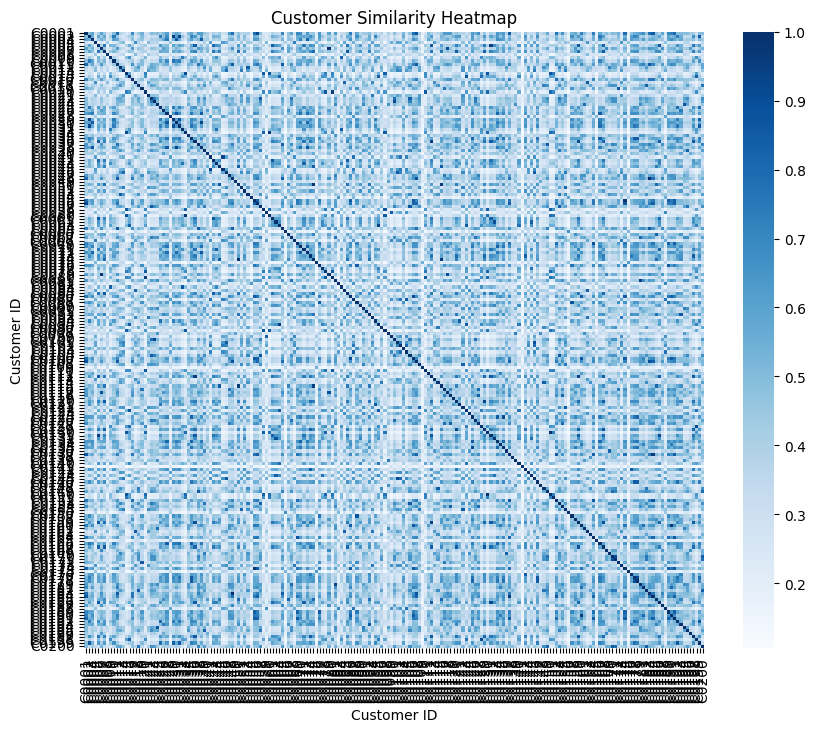

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the similarity matrix to visualize customer similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=customer_features['CustomerID'],
            yticklabels=customer_features['CustomerID'], cmap='Blues', annot=False)
plt.title('Customer Similarity Heatmap')
plt.xlabel('Customer ID')
plt.ylabel('Customer ID')
plt.show()



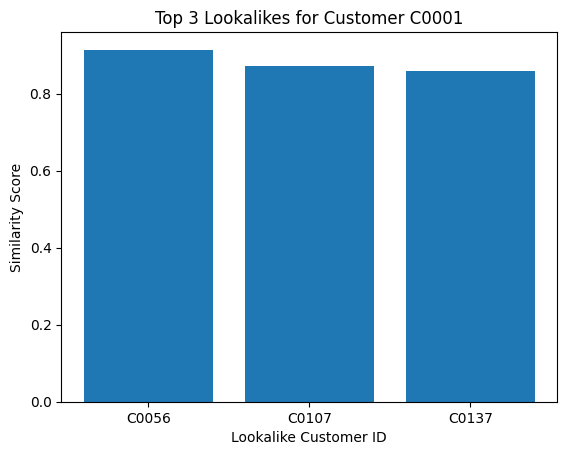

In [56]:
# Visualizing the top 3 lookalikes for a specific customer (e.g., C0001)
customer_id = 'C0001'
lookalikes = lookalike_recommendations[customer_id]

# Extract the lookalike IDs and similarity scores
lookalike_ids = [rec[0] for rec in lookalikes]
similarity_scores = [rec[1] for rec in lookalikes]

# Plot the similarity scores for the top 3 lookalikes
plt.bar(lookalike_ids, similarity_scores)
plt.xlabel('Lookalike Customer ID')
plt.ylabel('Similarity Score')
plt.title(f'Top 3 Lookalikes for Customer {customer_id}')
plt.show()

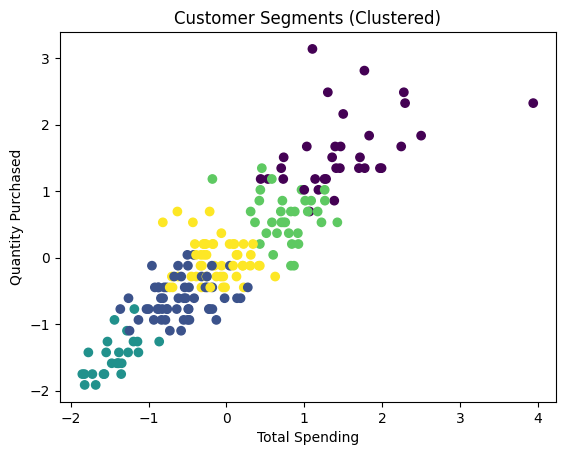

In [57]:
from sklearn.cluster import KMeans
import numpy as np

# Perform KMeans clustering to visualize customer segments
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(feature_matrix)

# Visualize clusters
plt.scatter(customer_features['TotalValue'], customer_features['Quantity'], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segments (Clustered)')
plt.xlabel('Total Spending')
plt.ylabel('Quantity Purchased')
plt.show()

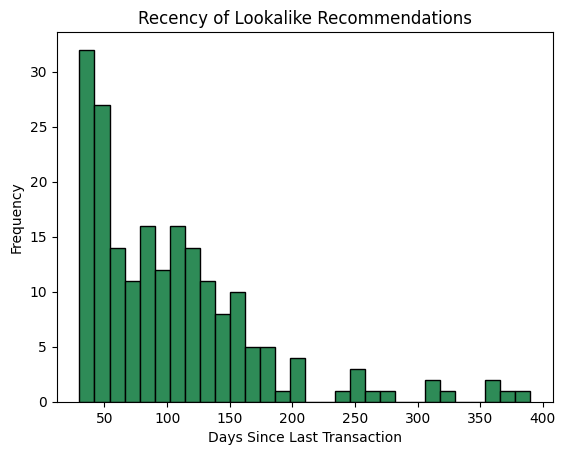

In [58]:
# Calculate the recency of the last transaction for lookalikes
merged_data['LastTransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
lookalike_recency = {}
for customer_id, recommendations in lookalike_recommendations.items():
    last_transaction = merged_data[merged_data['CustomerID'] == customer_id]['LastTransactionDate'].max()
    recency = (pd.to_datetime('today') - last_transaction).days
    lookalike_recency[customer_id] = recency

# Visualize recency of recommendations
plt.hist(list(lookalike_recency.values()), bins=30, color='seagreen', edgecolor='black')
plt.title('Recency of Lookalike Recommendations')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Frequency')
plt.show()
